In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)

from scipy.stats import f_oneway, chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Load dataset
dataset = pd.read_csv('/content/drive/MyDrive/LB Project/Jan_DS_2025_Project/Ds_Data.csv')

In [13]:
# Preview
dataset.head()

,destination,passanger,weather,temperature,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Accept(Y/N?)
0,No Urgent Place,Alone,Sunny,55,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0


In [ ]:
for i in dataset:
  print(f'-- {i} --')
  print(set(dataset[i].unique().tolist()))
  print('*'*50)

-- destination --
{'Home', 'Work', 'No Urgent Place'}
**************************************************
-- passanger --
{'Partner', 'Kid(s)', 'Friend(s)', 'Alone'}
**************************************************
-- weather --
{'Rainy', 'Sunny', 'Snowy'}
**************************************************
-- temperature --
{80, 30, 55}
**************************************************
-- coupon --
{'Carry out & Take away', 'Bar', 'Restaurant(20-50)', 'Coffee House', 'Restaurant(<20)'}
**************************************************
-- expiration --
{'2h', '1d'}
**************************************************
-- gender --
{'Male', 'Female'}
**************************************************
-- age --
{'31', '41', 'below21', '21', '46', '50plus', '26', '36'}
**************************************************
-- maritalStatus --
{'Married partner', 'Single', 'Widowed', 'Divorced', 'Unmarried partner'}
**************************************************
-- has_children --
{0, 1}
**

In [ ]:
# Shape
row, col = dataset.shape
print(f'Dataset contains {row} Rows & {col} Columns.')

Dataset contains 12684 Rows & 25 Columns.


In [ ]:
# Check duplicates
dataset.duplicated().sum()

291

In [ ]:
# Drop Duplicates
dataset.drop_duplicates(inplace=True)

In [ ]:
# Number of numerical & categorical features

num = []
cat = []
for feature in dataset.columns:
  if dataset[feature].dtype == 'O':
    cat.append(feature)
  else:
    num.append(feature)

print(f'There are {len(num)} Numerical & {len(cat)} Categorical Features.')

There are 8 Numerical & 17 Categorical Features.


In [ ]:
# Understanding categorical Features
for feature in cat:
  if len(dataset[feature].unique()) <= 2:
    print(f'{feature} -- {len(dataset[feature].unique())} unique value.')
  else:
    print(f'**{feature} -- {len(dataset[feature].unique())} unique value.')

**destination -- 3 unique value.
**passanger -- 4 unique value.
**weather -- 3 unique value.
**coupon -- 5 unique value.
expiration -- 2 unique value.
gender -- 2 unique value.
**age -- 8 unique value.
**maritalStatus -- 5 unique value.
**education -- 6 unique value.
**occupation -- 25 unique value.
**income -- 9 unique value.
**car -- 6 unique value.
**Bar -- 6 unique value.
**CoffeeHouse -- 6 unique value.
**CarryAway -- 6 unique value.
**RestaurantLessThan20 -- 6 unique value.
**Restaurant20To50 -- 6 unique value.


In [ ]:
# Information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12393 entries, 0 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12393 non-null  object
 1   passanger             12393 non-null  object
 2   weather               12393 non-null  object
 3   temperature           12393 non-null  int64 
 4   coupon                12393 non-null  object
 5   expiration            12393 non-null  object
 6   gender                12393 non-null  object
 7   age                   12393 non-null  object
 8   maritalStatus         12393 non-null  object
 9   has_children          12393 non-null  int64 
 10  education             12393 non-null  object
 11  occupation            12393 non-null  object
 12  income                12393 non-null  object
 13  car                   106 non-null    object
 14  Bar                   12287 non-null  object
 15  CoffeeHouse           12178 non-null  obj

Missing Value Treatment

In [ ]:
# Checking missing values
miss_gt25 = []
miss_lt25 = []
for feature in dataset.columns:
  if dataset[feature].isnull().mean() != 0:
    if dataset[feature].isnull().mean() > 0.25:
      miss_gt25.append(feature)
    else:
      miss_lt25.append(feature)

print('Missing value greater than 25% are', miss_gt25)
print('Missing value less than 25% are', miss_lt25)

Missing value greater than 25% are ['car']
Missing value less than 25% are ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']


In [ ]:
# Drop car feature as 99% data is missing
dataset.drop(columns='car', axis=1, inplace=True)

In [ ]:
# Missing value imputation
for feature in miss_lt25:
  if dataset[feature].dtype == 'O':
    dataset[feature] = dataset[feature].fillna(dataset[feature].mode()[0])
  else:
    dataset[feature] = dataset[feature].fillna(dataset[feature].median)

In [ ]:
dataset.isnull().sum().sum()

0

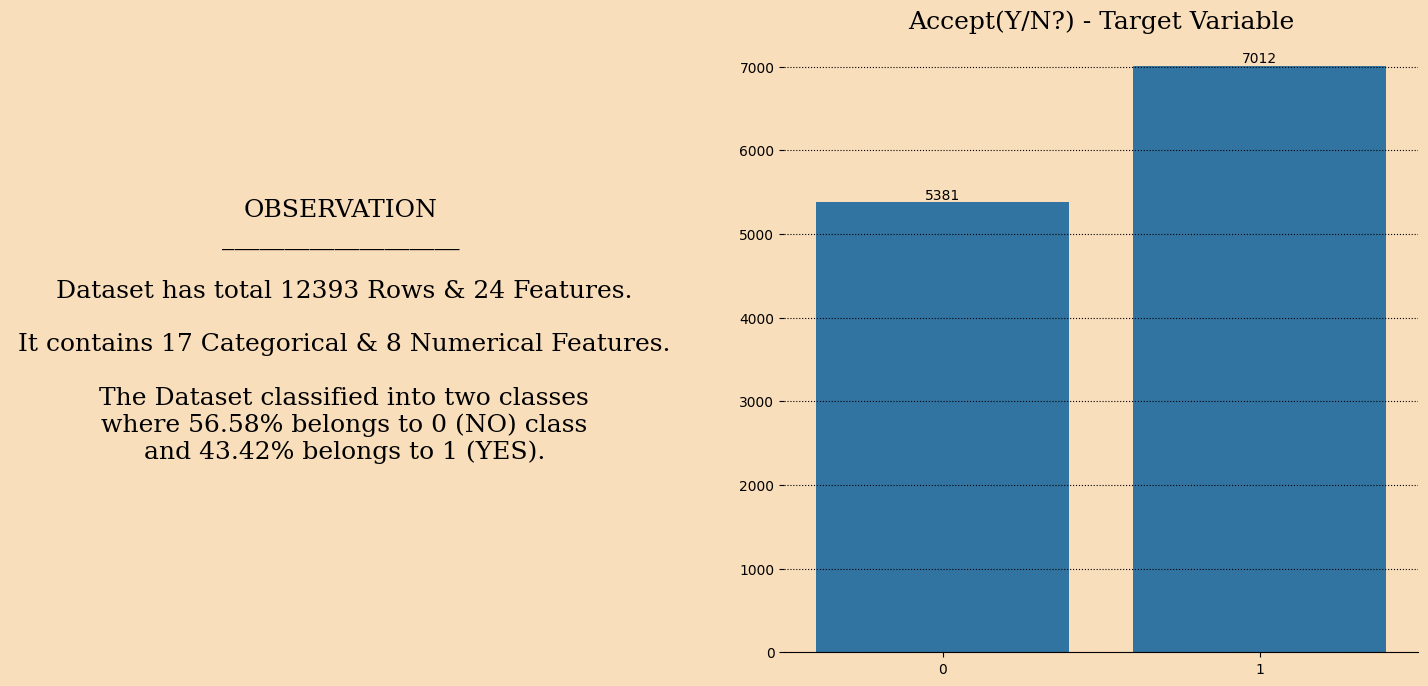

In [ ]:
# Creating plot structure
fig, axes = plt.subplots(1,2, figsize=(18,8))

# Adding color preference
bg_color = '#f9debc'
fig.set_facecolor(bg_color)
axes[0].set_facecolor(bg_color)
axes[1].set_facecolor(bg_color)

# Plot graph
ax = sns.countplot(x=dataset['Accept(Y/N?)'], ax=axes[1])
ax.bar_label(ax.containers[0])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title('Accept(Y/N?) - Target Variable', size=18, family='serif')
axes[1].grid(axis='y', ls=':', color='#000000')

row, col = dataset.shape
max, min = round(dataset['Accept(Y/N?)'].value_counts(normalize=True)*100,2)
axes[0].text(0.5,0.5, f'''OBSERVATION\n___________________\n\n Dataset has total {row} Rows & {col} Features.

 It contains {len(cat)} Categorical & {len(num)} Numerical Features.

 The Dataset classified into two classes
 where {max}% belongs to 0 (NO) class
 and {min}% belongs to 1 (YES).
 ''',
             ha='center',va='center',size=18,family='serif')

# Removing spines & axis
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)
for position in ['left','right','top','bottom']:
  for i in range(2):
    if position=='bottom' and i==1:
      continue
    else:
      axes[i].spines[position].set_visible(False)

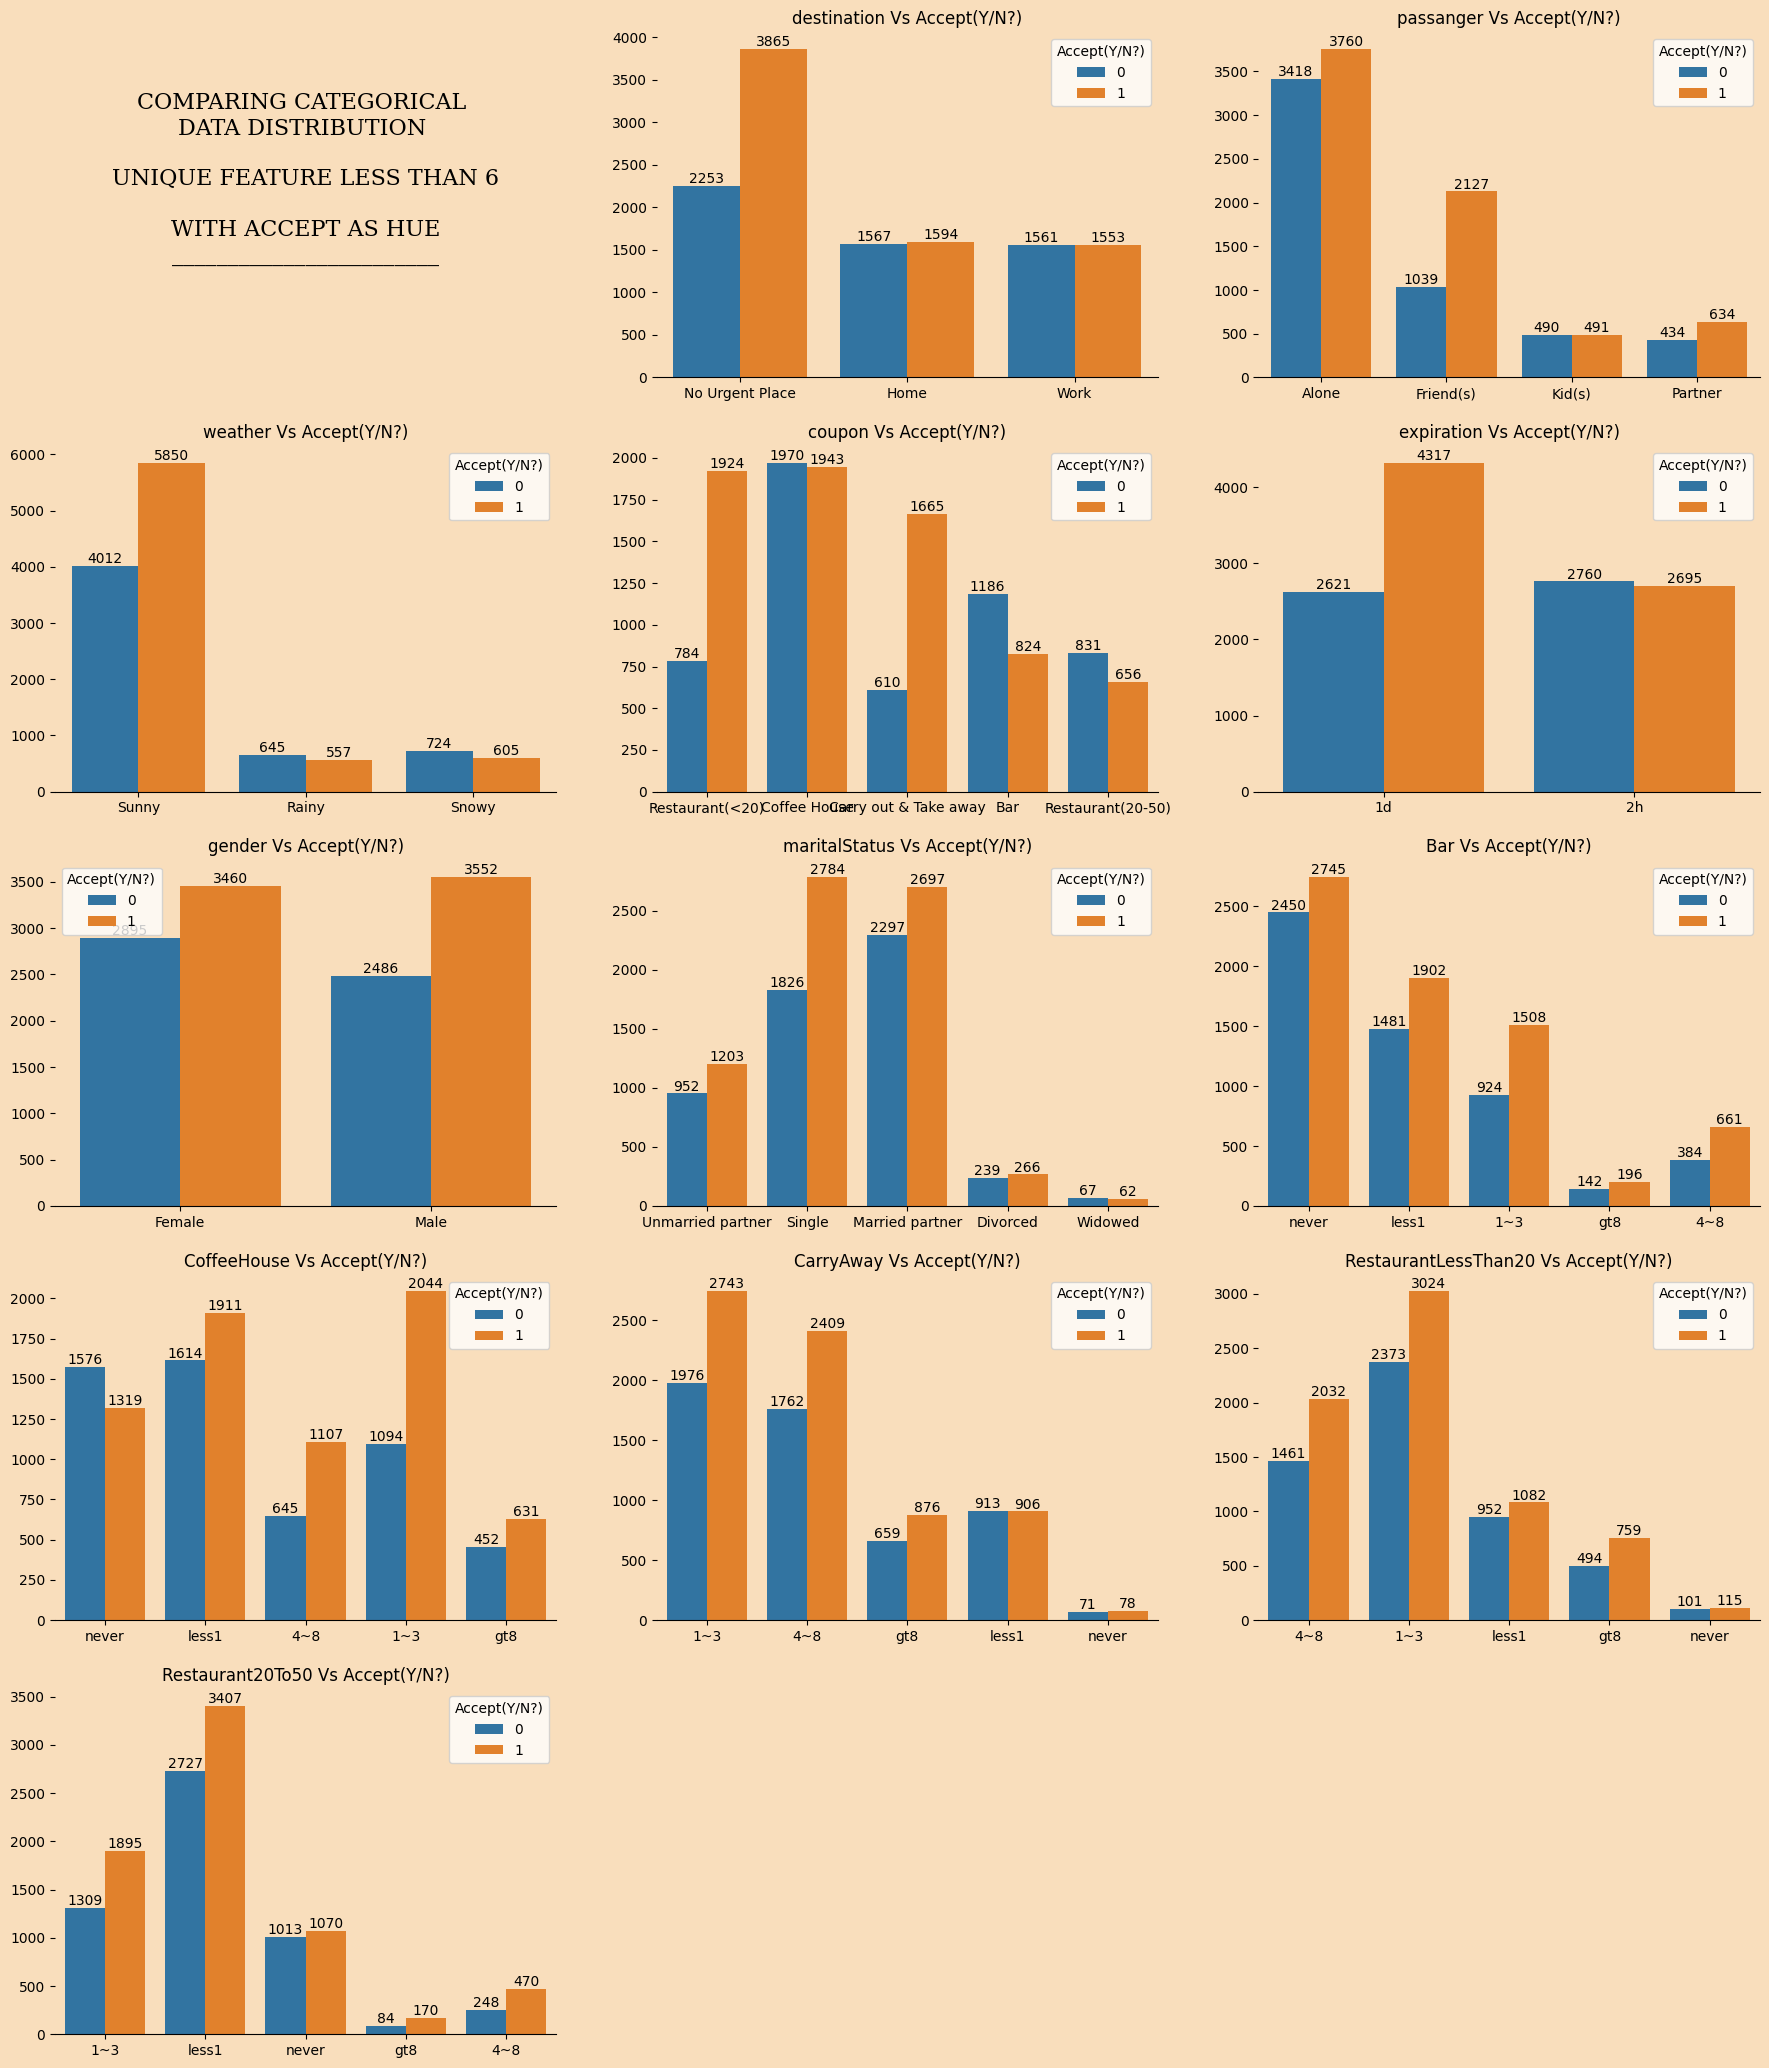

In [ ]:
# Extracting categorical features
cat_lt_6 = []
for feature in dataset.columns:
  if dataset[feature].dtype=='O' and len(dataset[feature].unique())<6:
    cat_lt_6.append(feature)

# Creating plot structure
fig, axes = plt.subplots(5,3, figsize=(22,26))
axes = axes.ravel()

# Adding color preference
bg_color = '#f9debc'
fig.set_facecolor(bg_color)
for a in range(15):
  axes[a].set_facecolor(bg_color)

idx = 0
for i in range(15):
  try:
    if i == 0:
      continue
    else:
      cplot = sns.countplot(data=dataset, x=cat_lt_6[idx], hue='Accept(Y/N?)', ax=axes[i])
      for container in cplot.containers:
        cplot.bar_label(container)
      axes[i].set_xlabel('')
      axes[i].set_ylabel('')
      axes[i].set_title(f'{cat_lt_6[idx]} Vs Accept(Y/N?)')

      for position in ['left','right','top']:
        axes[i].spines[position].set_visible(False)

      idx+=1

  except:
    for position in ['left','right','top','bottom']:
      axes[i].spines[position].set_visible(False)
    axes[i].xaxis.set_visible(False)
    axes[i].yaxis.set_visible(False)
    idx+=1

axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)
axes[0].text(0.5,0.5, 'COMPARING CATEGORICAL \nDATA DISTRIBUTION \n\n\
UNIQUE FEATURE LESS THAN 6\n\n\
WITH ACCEPT AS HUE\n________________________\n\n',
             ha='center', va='center', size=16, family='serif', weight=500)
for position in ['left','right','top','bottom']:
  axes[0].spines[position].set_visible(False)

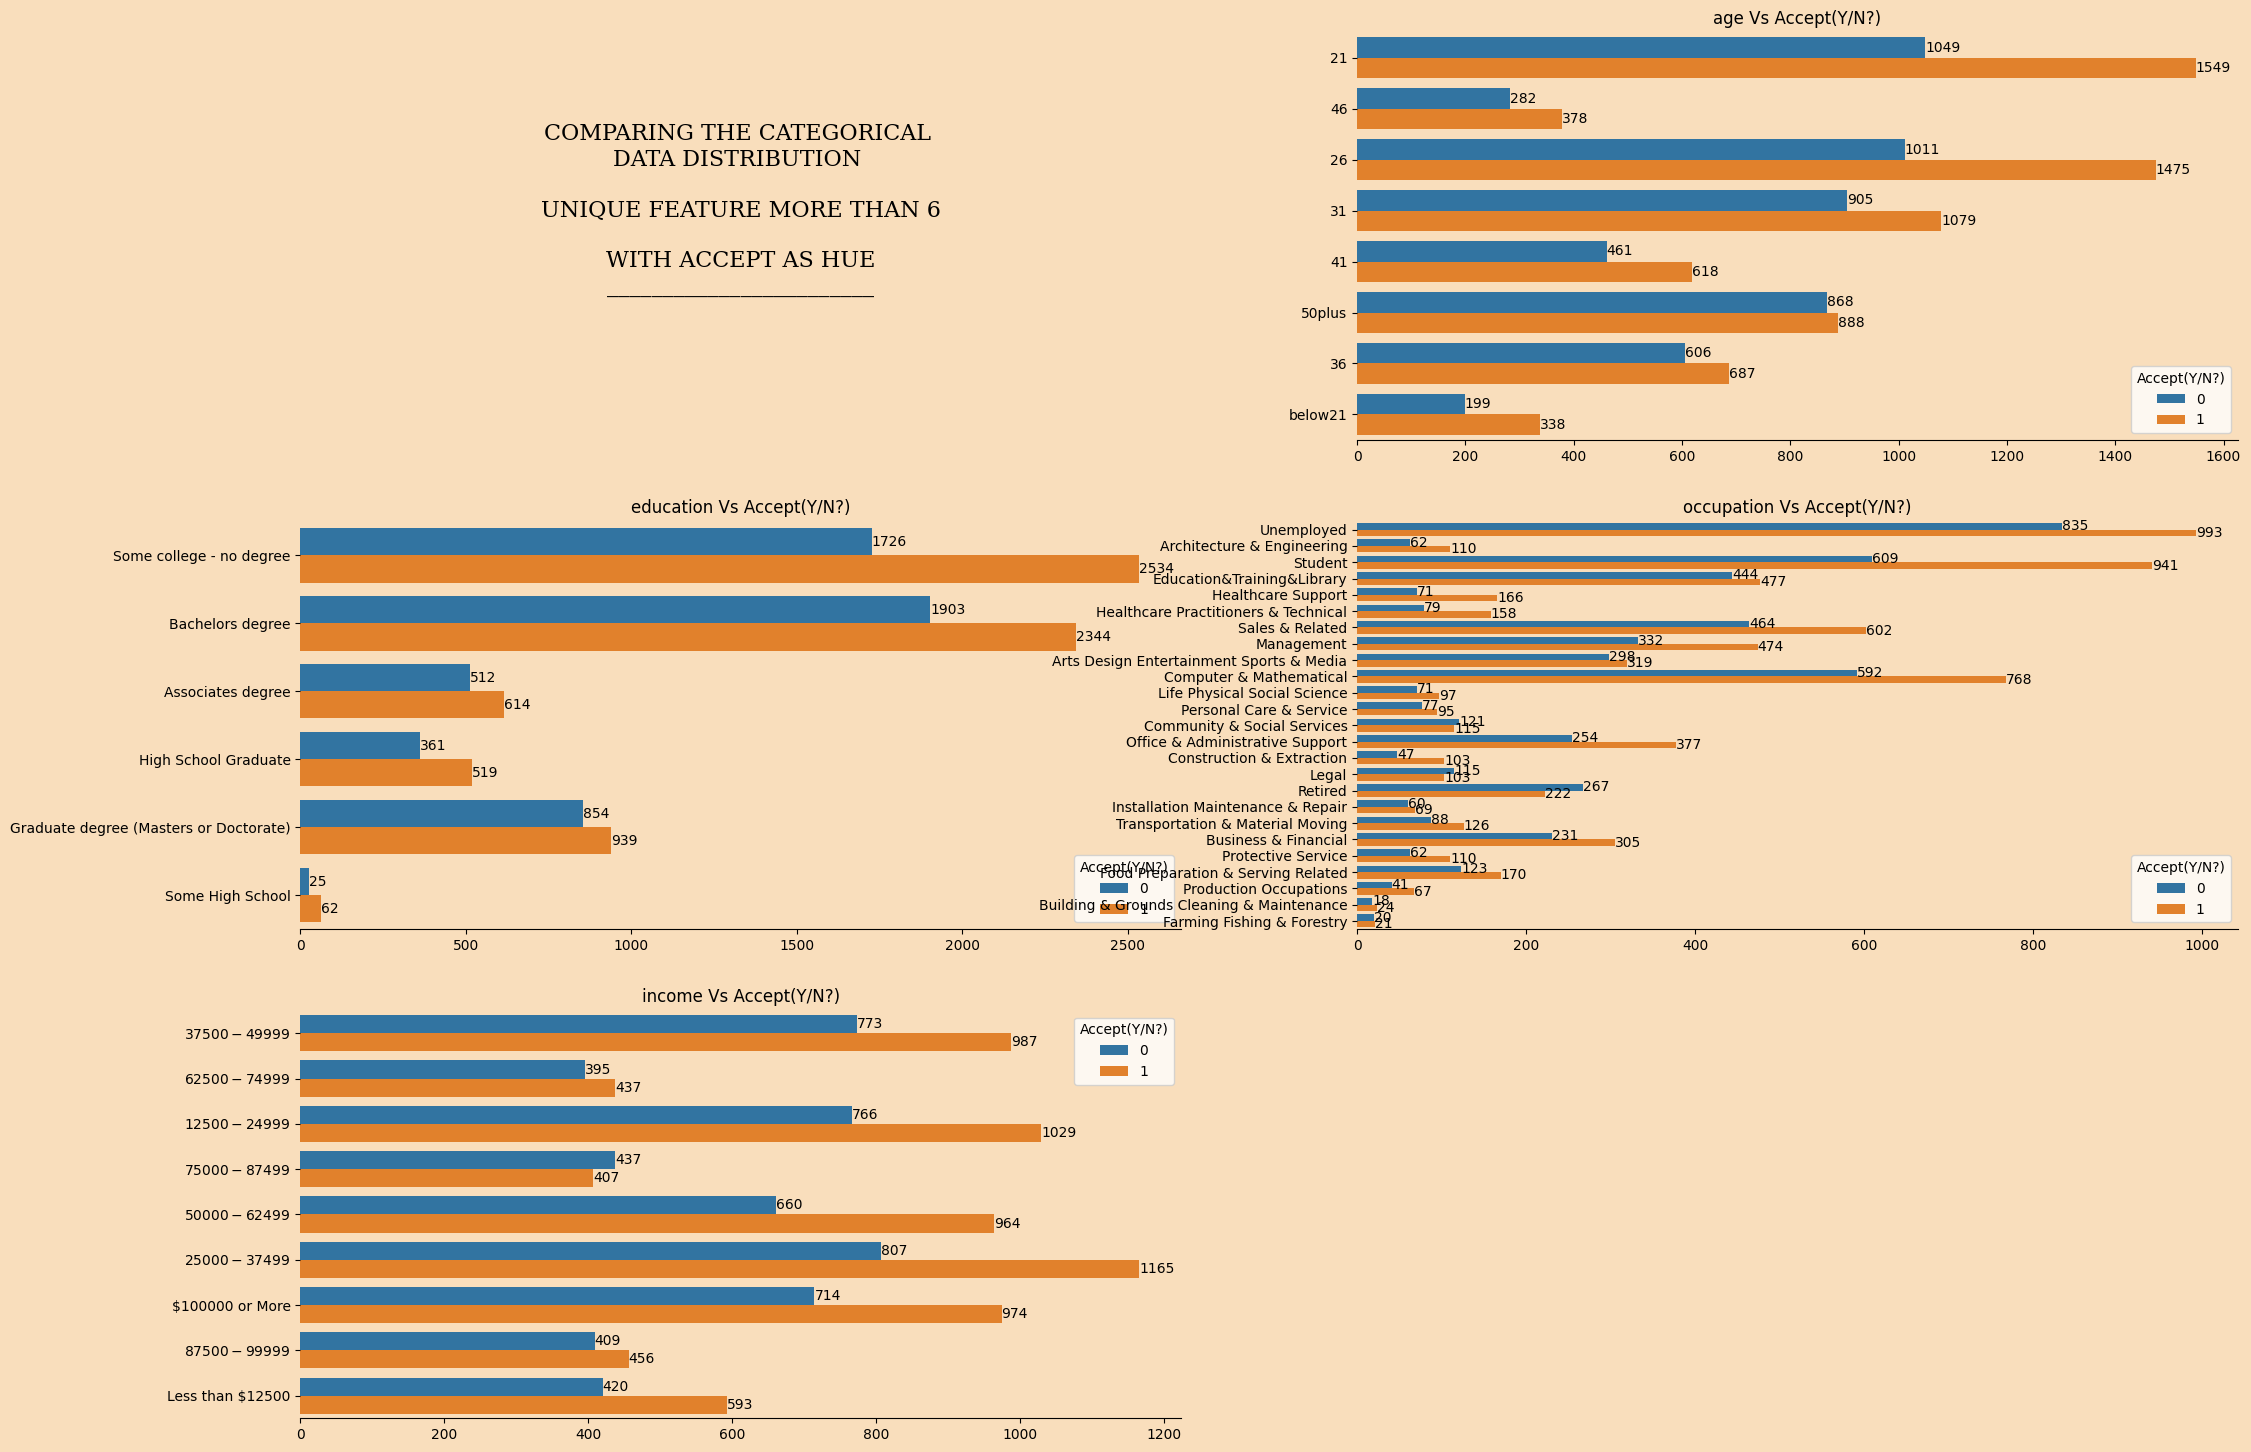

In [ ]:
# Extracting categorical features
cat_gt_6 = []
for feature in dataset.columns:
  if dataset[feature].dtype=='O' and len(dataset[feature].unique())>=6:
    cat_gt_6.append(feature)

# Creating plot structure
fig, axes = plt.subplots(3,2, figsize=(25,18))
axes = axes.ravel()

# Adding color preference
bg_color = '#f9debc'
fig.set_facecolor(bg_color)
for a in range(6):
  axes[a].set_facecolor(bg_color)

idx = 0
for i in range(6):
  try:
    if i == 0:
      continue
    else:
      cplot = sns.countplot(data=dataset, y=cat_gt_6[idx], hue='Accept(Y/N?)', ax=axes[i])
      for container in cplot.containers:
        cplot.bar_label(container)
      axes[i].set_xlabel('')
      axes[i].set_ylabel('')
      axes[i].set_title(f'{cat_gt_6[idx]} Vs Accept(Y/N?)')

      for position in ['left','right','top']:
        axes[i].spines[position].set_visible(False)

      idx+=1

  except:
    for position in ['left','right','top','bottom']:
      axes[i].spines[position].set_visible(False)
    axes[i].xaxis.set_visible(False)
    axes[i].yaxis.set_visible(False)
    idx+=1

axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)
axes[0].text(0.5,0.5, 'COMPARING THE CATEGORICAL \nDATA DISTRIBUTION \n\n\
UNIQUE FEATURE MORE THAN 6\n\n\
WITH ACCEPT AS HUE\n________________________\n\n',
             ha='center', va='center', size=16, family='serif', weight=500)
for position in ['left','right','top','bottom']:
  axes[0].spines[position].set_visible(False)

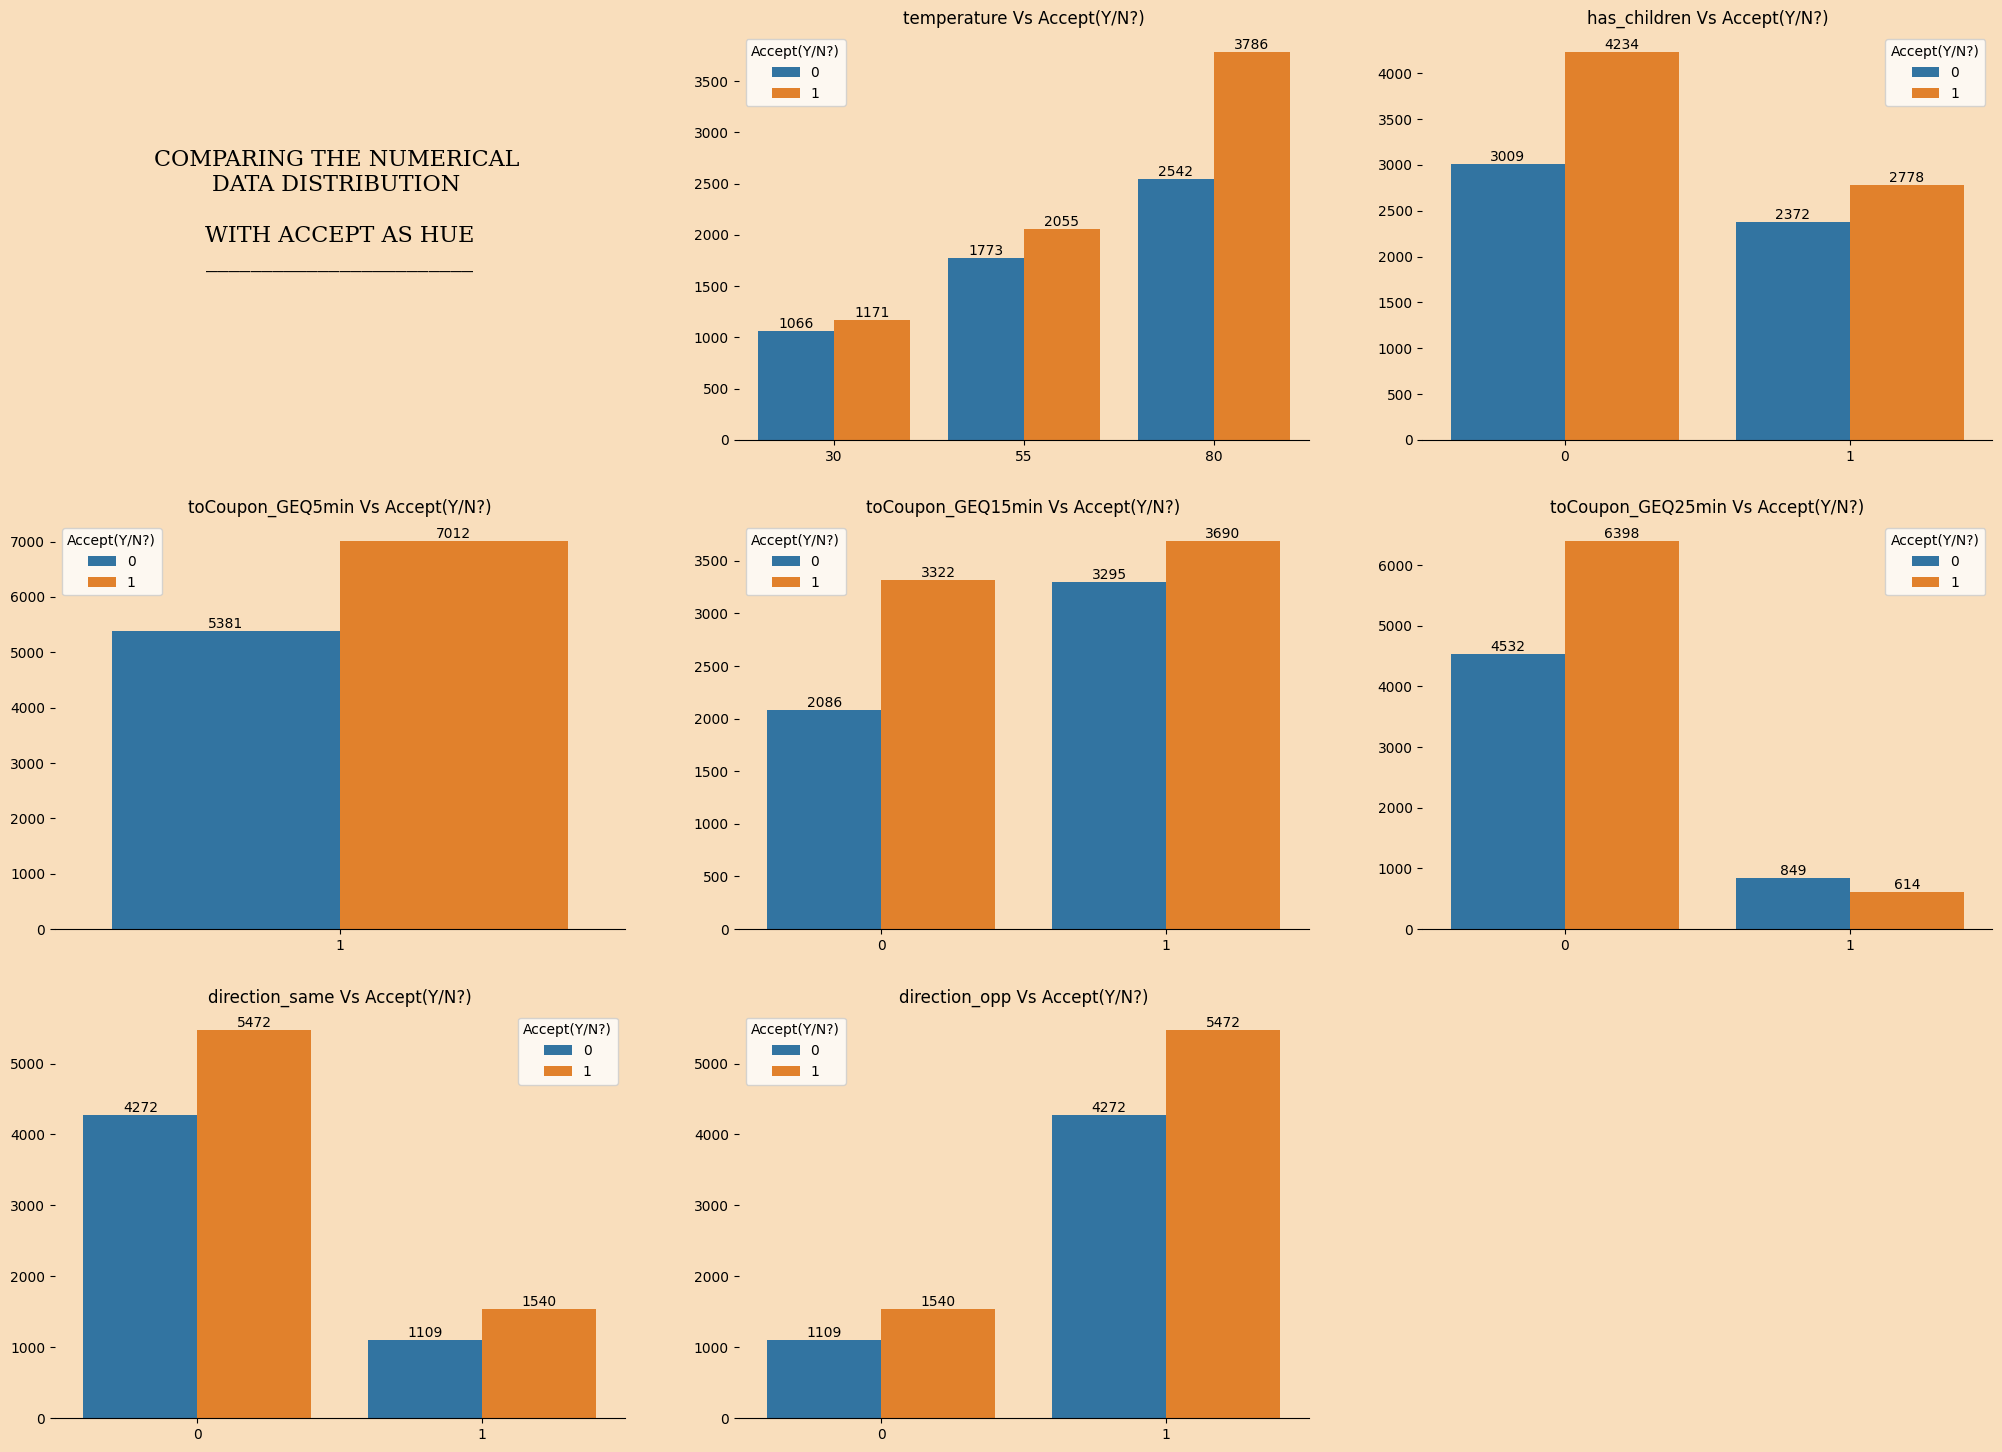

In [ ]:
# Extracting categorical features
num_graph = []
for feature in dataset.columns:
  if dataset[feature].dtype!='O' and feature != 'Accept(Y/N?)':
    num_graph.append(feature)

# Creating plot structure
fig, axes = plt.subplots(3,3, figsize=(25,18))
axes = axes.ravel()

# Adding color preference
bg_color = '#f9debc'
fig.set_facecolor(bg_color)
for a in range(9):
  axes[a].set_facecolor(bg_color)

idx = 0
for i in range(9):
  try:
    if i == 0:
      continue
    else:
      cplot = sns.countplot(data=dataset, x=num_graph[idx], hue='Accept(Y/N?)', ax=axes[i])
      for container in cplot.containers:
        cplot.bar_label(container)
      axes[i].set_xlabel('')
      axes[i].set_ylabel('')
      axes[i].set_title(f'{num_graph[idx]} Vs Accept(Y/N?)')

      for position in ['left','right','top']:
        axes[i].spines[position].set_visible(False)

      idx+=1

  except:
    for position in ['left','right','top','bottom']:
      axes[i].spines[position].set_visible(False)
    axes[i].xaxis.set_visible(False)
    axes[i].yaxis.set_visible(False)
    idx+=1

axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)
axes[0].text(0.5,0.5, 'COMPARING THE NUMERICAL \nDATA DISTRIBUTION \n\n\
WITH ACCEPT AS HUE\n________________________\n\n',
             ha='center', va='center', size=16, family='serif', weight=500)
for position in ['left','right','top','bottom']:
  axes[0].spines[position].set_visible(False)

Inferences:

* Destination: "No Urgent Place" destinations show highest coupon usage
* Passenger: Solo travelers most likely to use coupons
* Weather: Sunny weather & high temperature correlates with higher coupon acceptance
* Travel Direction: Coupons aligned with travel direction have much higher acceptance
* Coupon Type: Restaurant with price less than 20 and carry-out options are most popular
* Expiry: 1 Day significantly increase acceptance
* Bar Coupons: It has low acceptance rates. Explore alternative strategies for bar promotions.
* Coffee House: Moderate acceptance. Potential for increased engagement with targeted campaigns.
* Carry Away: Moderate acceptance. Opportunities to promote more frequent carry-away purchases.
* Restaurant less than 20: High acceptance, confirming preference for affordable dining.
* Restaurant between 20-50: Lower acceptance than cheaper options. Consider price sensitivity.
* Gender: Females slightly more likely to use coupons than males.
* Marital Status: Unmarried partner and Single show highest acceptance
* Age: Youngest (25-29) and oldest (50+) groups show higher acceptance, but the relationship with age is complex
* Education: Higher education levels strongly correlate with increased coupon acceptance.
* Occupation: Certain occupations (e.g., "Healthcare Practitioners") show higher acceptance. Analyze occupation-based trends.
* Income: Higher income levels strongly correlate with increased coupon acceptance. Prioritize higher-income targeting.
* Individuals without children are more likely to accept coupons.





In [ ]:
# Combining driving distance columns
drive_time = []
for i in range(dataset.shape[0]):
  if (dataset['toCoupon_GEQ15min'].iloc[i]) == 0:
    drive_time.append('Less than 15')
  elif (dataset['toCoupon_GEQ15min'].iloc[i]==1) and (dataset['toCoupon_GEQ25min'].iloc[i]==0):
    drive_time.append('15 to 25')
  else:
    drive_time.append('More than 25')

dataset['toCoupon_time'] = drive_time

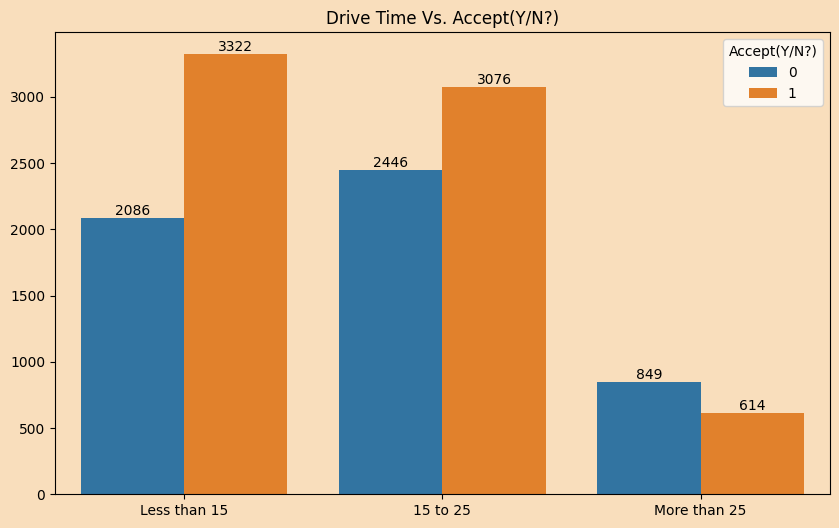

In [ ]:
fig = plt.figure(figsize=(10,6))
fig.set_facecolor(bg_color)
d_time = sns.countplot(data=dataset, x='toCoupon_time', hue='Accept(Y/N?)')
for container in d_time.containers:
  d_time.bar_label(container)
d_time.set_facecolor(bg_color)
d_time.set_xlabel('')
d_time.set_ylabel('')
d_time.set_title('Drive Time Vs. Accept(Y/N?)')

plt.show()

* Less drive time coupons are more likely to be accepted than drive time more than 25 minutes

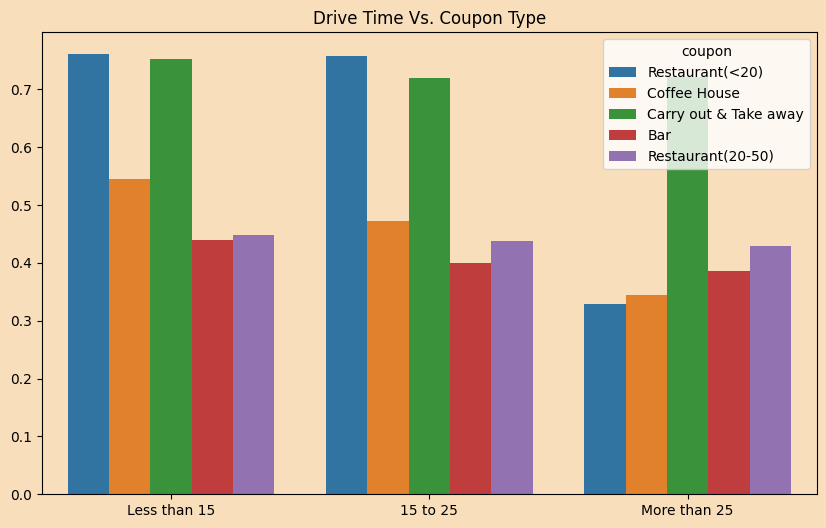

In [ ]:
fig = plt.figure(figsize=(10,6))
fig.set_facecolor(bg_color)
d_time = sns.barplot(data=dataset, x='toCoupon_time', y = 'Accept(Y/N?)', hue='coupon', ci=None)
d_time.set_facecolor(bg_color)
d_time.set_xlabel('')
d_time.set_ylabel('')
d_time.set_title('Drive Time Vs. Coupon Type')

plt.show()

In [ ]:
# Drop columns
dataset.drop(columns=['toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min'], axis=1, inplace=True)

Statistical Analysis

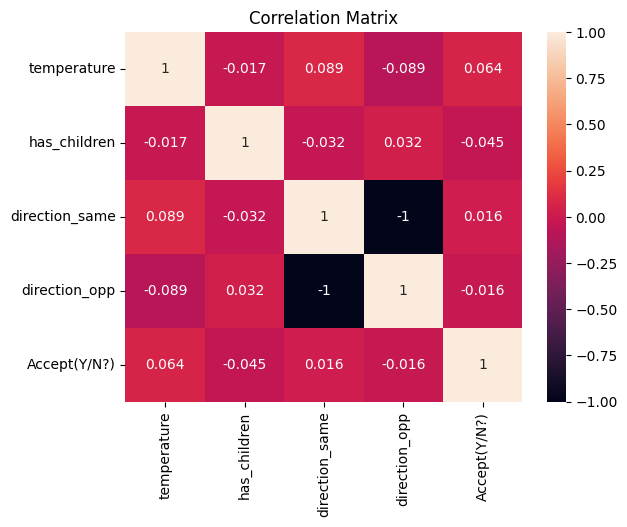

In [ ]:
# Correlation
sns.heatmap(dataset.corr(numeric_only=True), annot=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Anova Test
num = []
for i in dataset:
  if dataset[i].dtypes != 'O' and i != 'Accept(Y/N?)':
    num.append(i)

for i in num:
  a = list(dataset[i])
  b = list(dataset['Accept(Y/N?)'])

  group_0 = [value for value, group in zip(a,b) if group==0]
  group_1 = [value for value, group in zip(a,b) if group==1]

  f_stats, p_val = f_oneway(group_0, group_1)

  if p_val <= 0.05:
    print(f'{i} -- {p_val} -- significant')
  else:
    print(f'{i} -- {p_val} -- non significant')

temperature -- 9.357855571586499e-13 -- significant
has_children -- 5.756347638998224e-07 -- significant
direction_same -- 0.06864552261864745 -- non significant
direction_opp -- 0.06864552261864745 -- non significant


In [ ]:
# Drop direction_opp, direction_same as it is non-significant
dataset.drop(columns=['direction_opp','direction_same'], axis=1, inplace=True)

In [ ]:
# Chi-Square Test
cat = []
for i in dataset:
  if dataset[i].dtypes == 'O':
    cat.append(i)

for i in cat:
  chi2, p_val,_,_ = chi2_contingency(pd.crosstab(dataset[i], dataset['Accept(Y/N?)']))

  if p_val <= 0.05:
    print(f'{i} -- {p_val} -- significant')
  else:
    print(f'{i} -- {p_val} -- non significant')

destination -- 3.315606251130289e-47 -- significant
passanger -- 1.0144668957924846e-46 -- significant
weather -- 9.095775566072616e-33 -- significant
coupon -- 8.078113579933398e-184 -- significant
expiration -- 3.2069490154075797e-46 -- significant
gender -- 9.515822687284084e-07 -- significant
age -- 4.5267556076001646e-11 -- significant
maritalStatus -- 8.673752412913449e-10 -- significant
education -- 4.652513690287145e-08 -- significant
occupation -- 1.4885294061490842e-14 -- significant
income -- 1.0027981309550821e-07 -- significant
Bar -- 4.324369367509157e-16 -- significant
CoffeeHouse -- 9.86145649406117e-59 -- significant
CarryAway -- 1.5618842337841763e-08 -- significant
RestaurantLessThan20 -- 0.00013417473757547274 -- significant
Restaurant20To50 -- 4.90685693311738e-14 -- significant
toCoupon_time -- 6.101757371369505e-40 -- significant


Encoding

In [ ]:
dataset = pd.get_dummies(data=dataset, columns=cat, drop_first=True, dtype='int')

In [ ]:
dataset.rename(columns={'coupon_Restaurant(<20)':'coupon_Restaurant(lt_20)'}, inplace=True)

Training & Validation Split

In [ ]:
x = dataset.drop('Accept(Y/N?)', axis=1)
y = dataset['Accept(Y/N?)']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(9914, 85)
(2479, 85)


Model Selection

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'AdaBoost':AdaBoostClassifier(),
    'Bagging':BaggingClassifier(),
    'KNN':KNeighborsClassifier(),
    'BernoulliNB':BernoulliNB(),
    'MultinomialNB':MultinomialNB(),
    'XGBoost': XGBClassifier()
}

In [ ]:
result = {}
for name, model in models.items():
  # Model fit
  model.fit(x_train, y_train)

  # Predict
  y_pred_train = model.predict(x_train)
  y_pred_test = model.predict(x_test)

  # Evaluation
  train_accuracy = accuracy_score(y_train, y_pred_train)
  test_accuracy = accuracy_score(y_test, y_pred_test)

  result[name] = (train_accuracy, test_accuracy)
  print(f'**** {name} ****')
  print(f'Training Accuracy:- {round(train_accuracy,2)}%')
  print(f'Testing Accuracy:- {round(test_accuracy,2)}%')
  print('-'*40)

**** LogisticRegression ****
Training Accuracy:- 0.68%
Testing Accuracy:- 0.68%
----------------------------------------
**** DecisionTree ****
Training Accuracy:- 0.99%
Testing Accuracy:- 0.67%
----------------------------------------
**** RandomForest ****
Training Accuracy:- 0.99%
Testing Accuracy:- 0.73%
----------------------------------------
**** GradientBoosting ****
Training Accuracy:- 0.73%
Testing Accuracy:- 0.7%
----------------------------------------
**** AdaBoost ****
Training Accuracy:- 0.68%
Testing Accuracy:- 0.67%
----------------------------------------
**** Bagging ****
Training Accuracy:- 0.98%
Testing Accuracy:- 0.71%
----------------------------------------
**** KNN ****
Training Accuracy:- 0.78%
Testing Accuracy:- 0.63%
----------------------------------------
**** BernoulliNB ****
Training Accuracy:- 0.66%
Testing Accuracy:- 0.66%
----------------------------------------
**** MultinomialNB ****
Training Accuracy:- 0.66%
Testing Accuracy:- 0.66%
---------------

In [ ]:
model_name = []
train_acc = []
test_acc = []
for name, score in result.items():
  model_name.append(name)
  train_acc.append(round(score[0]*100,2))
  test_acc.append(round(score[1]*100,2))

In [ ]:
model_eval = pd.DataFrame({
                        'Model':model_name,
                        'Train_Accuracy':train_acc,
                        'Test_Accuracy':test_acc})
model_eval['Variance'] = model_eval['Train_Accuracy'] - model_eval['Test_Accuracy']
model_eval

,Model,Train_Accuracy,Test_Accuracy,Variance
0,LogisticRegression,68.48,67.97,0.51
1,DecisionTree,99.04,67.41,31.63
2,RandomForest,99.04,73.17,25.87
3,GradientBoosting,72.99,70.15,2.84
4,AdaBoost,68.20,67.08,1.12
5,Bagging,97.70,70.84,26.86
6,KNN,77.86,63.37,14.49
7,BernoulliNB,66.31,65.83,0.48
8,MultinomialNB,65.99,65.87,0.12
9,XGBoost,88.65,73.94,14.71


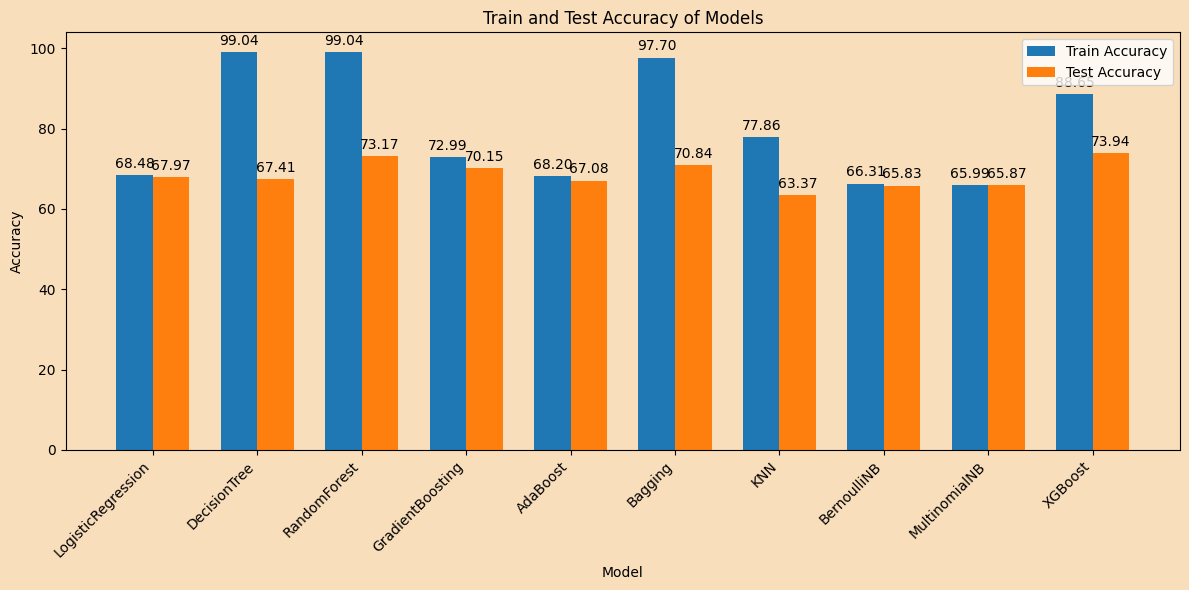

In [ ]:
x = np.arange(len(model_eval['Model']))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
bars1 = ax.bar(x - width/2, model_eval['Train_Accuracy'], width, label='Train Accuracy')
bars2 = ax.bar(x + width/2, model_eval['Test_Accuracy'], width, label='Test Accuracy')

ax.bar_label(bars1, padding=3, fmt='%.2f')
ax.bar_label(bars2, padding=3, fmt='%.2f')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test Accuracy of Models')
ax.set_xticks(x)
ax.set_xticklabels(model_eval['Model'], rotation=45, ha='right')

ax.legend()

plt.tight_layout()
plt.show()


Hyper Parameter

In [ ]:
# Gradient Boosting
gb_param = {
    'learning_rate':[0.05,0.1,0.2],
    'n_estimators':[50,100,150],
    'max_depth':[3,5,7]
}

In [ ]:
gb_model = GradientBoostingClassifier()
grid_cv = GridSearchCV(
    estimator = gb_model,
    param_grid = gb_param,
    scoring = 'accuracy',
    cv = 10
)

In [ ]:
grid_cv.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [ ]:
gb_best_param = grid_cv.best_params_
gb_best_param

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}

In [ ]:
gboost = GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=150)
gboost.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=150)

Training Accuracy 0.97
-------------------------
Testing Accuracy 0.74
*******************************************************
Train
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4271
           1       0.96      0.98      0.97      5643

    accuracy                           0.97      9914
   macro avg       0.97      0.96      0.97      9914
weighted avg       0.97      0.97      0.97      9914

-------------------------------------------------------
Test
              precision    recall  f1-score   support

           0       0.73      0.68      0.70      1110
           1       0.75      0.79      0.77      1369

    accuracy                           0.74      2479
   macro avg       0.74      0.74      0.74      2479
weighted avg       0.74      0.74      0.74      2479

*******************************************************


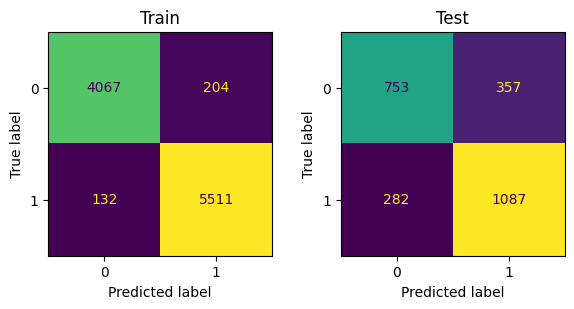

In [ ]:
# Predict
y_pred_train = gboost.predict(x_train)
y_pred_test = gboost.predict(x_test)

# Accuracy
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print('Training Accuracy', round(train_acc, 2))
print(f'-'*25)
print('Testing Accuracy', round(test_acc, 2))
print(f'*'*55)

# Classification Report
print('Train')
print(classification_report(y_train, y_pred_train))
print(f'-'*55)
print('Test')
print(classification_report(y_test, y_pred_test))
print(f'*'*55)

# Confusion Matrix
fig, axes = plt.subplots(1,2, figsize=(6,3))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, ax=axes[0], colorbar=False)
axes[0].set_title('Train')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=axes[1], colorbar=False)
axes[1].set_title('Test')
plt.tight_layout()
plt.show()


In [ ]:
# ROC-AUC Curve
roc = roc_auc_score(y_test , y_pred_test)
fpr,tpr,thresholds = roc_curve(y_test , y_pred_test)

In [ ]:
plt.figure()

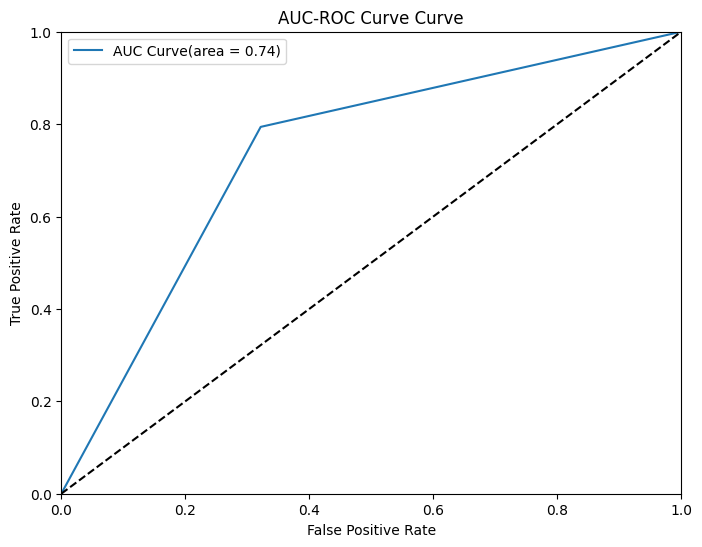

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label = 'AUC Curve(area = %0.2f)' %roc)
plt.plot([0,1] , [0,1] , 'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve Curve')
plt.legend()
plt.show()